In [1]:
import os
import geopandas as gpd
from water_quality.tiling import get_aoi_tiles
from water_quality.instruments import check_instrument_dates
from water_quality.load_data import build_dc_queries, build_wq_dataset
from odc.geo.geom import Geometry
from water_quality.water_detection import water_analysis
from water_quality.pixel_corrections import R_correction
from water_quality.hue import hue_calculation
from water_quality.logs import setup_logging
from water_quality.instruments import get_instruments_list
from water_quality.optical_water_type import OWT_pixel
from water_quality.wq_algorithms import WQ_vars, ALGORITHMS_CHLA, ALGORITHMS_TSM

In [2]:
%load_ext memory_profiler

In [3]:
%load_ext autoreload
%autoreload 2
# To automatically reload modules when they change:

In [4]:
test_data_dir = "../tests/data"

In [5]:
# Analysis parameters:
# The area of interest run over.
place_name = "SA_smalldam"
# Time range to run the analysis over
start_date = "2023"
end_date = "2024"
# Set a list of 'instruments' to be used in the analysis
instruments_to_use = {
    'oli_agm'  : {'use': True },
    'oli'      : {'use': False},
    'msi_agm'  : {'use': True },
    'msi'      : {'use': False},
    'tm_agm'   : {'use': True },
    'tm'       : {'use': False},
    'tirs'     : {'use': False},  
    'wofs_ann' : {'use': True },
    'wofs_all' : {'use': True },  # wofs_all will be removed as it is better to derive from wofs_ann
    }
WFTH = water_frequency_threshold_high = 0.5    #this threshold targets areas that are as like as not to be water at any time.
WFTL = water_frequency_threshold_low  = 0.1    #for pixel processing (rather than during summation)
PWT  = permanent_water_threshold      = 0.875  #used to map annual permanent water (value arrived at through testing)
SC   = sigma_coefficient              = 1.2    #used to map annual permanent water (value arrived at through tessting)

In [6]:
log = setup_logging()

In [7]:
# Load area of interests 
places_fp =  os.path.join("../tests/data", "places.parquet")
places = gpd.read_parquet(places_fp)

# Select extract an AOI for a given placenam.
place = places[places["name"].isin([place_name])]
place

,name,run,desc,geometry
30,SA_smalldam,True,"Irrigation Dam, South Africa","POLYGON ((19.498 -33.802, 19.498 -33.8, 19.494..."


In [8]:
# Get the tiles covering the area of interest chosen
place_geom = Geometry(geom=place.iloc[0].geometry, crs=place.crs)
tiles = get_aoi_tiles(place_geom)
tiles = list(tiles)
tiles

[((601, 103),
  GeoBox((3200, 3200), Affine(10.0, 0.0, 1856000.0,
         0.0, -10.0, -4064000.0), CRS('EPSG:6933')))]

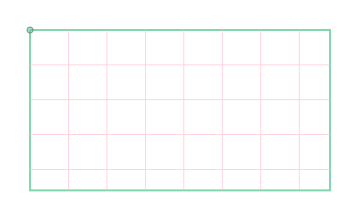

In [9]:
# Select a single tile to test continental processing over
tile = tiles[0]
tile_idx = tile[0]
tile_geobox = tile[1]

# Make tile geobox smaller
from odc.geo.geobox import GeoBox
tile_geobox = GeoBox.from_geopolygon(place_geom, tile_geobox.resolution, tile_geobox.crs)

tile_geobox

In [10]:
print(tile_geobox)

GeoBox((23, 39), Affine(10.0, 0.0, 1880900.0,
       0.0, -10.0, -4071810.0), CRS('EPSG:6933'))


In [11]:
# --- don't try to use instruments for which there are no data 
instruments_to_use = check_instrument_dates(instruments_to_use, start_date, end_date)
instruments_to_use

2025-06-10 23:07:17,884 water_quality.instruments [ERROR]: Instrument tm_agm has the date ranges 1990-01-01 to 2012-12-31 which is outside the supplied date range of 2023-01-01 to 2024-12-31.


{'oli_agm': {'use': True},
 'oli': {'use': False},
 'msi_agm': {'use': True},
 'msi': {'use': False},
 'tm_agm': {'use': False},
 'tm': {'use': False},
 'tirs': {'use': False},
 'wofs_ann': {'use': True},
 'wofs_all': {'use': True}}

In [12]:
instruments_list = get_instruments_list(instruments_to_use)
instruments_list

{'oli_agm': {'SR_B2': {'varname': 'oli02_agm',
   'parameters': (True, '450-510')},
  'SR_B3': {'varname': 'oli03_agm', 'parameters': (True, '530-590')},
  'SR_B4': {'varname': 'oli04_agm', 'parameters': (True, '640-670')},
  'SR_B5': {'varname': 'oli05_agm', 'parameters': (True, '850-880')},
  'SR_B6': {'varname': 'oli06_agm', 'parameters': (True, '1570-1650')},
  'SR_B7': {'varname': 'oli07_agm', 'parameters': (True, '2110-2290')},
  'smad': {'varname': 'oli_agm_smad', 'parameters': (True,)},
  'count': {'varname': 'oli_agm_count', 'parameters': (True,)}},
 'msi_agm': {'B02': {'varname': 'msi02_agm', 'parameters': (True, '460-525')},
  'B03': {'varname': 'msi03_agm', 'parameters': (True,)},
  'B04': {'varname': 'msi04_agm', 'parameters': (True,)},
  'B05': {'varname': 'msi05_agm', 'parameters': (True,)},
  'B06': {'varname': 'msi06_agm', 'parameters': (True,)},
  'B07': {'varname': 'msi07_agm', 'parameters': (True,)},
  'B12': {'varname': 'msi12_agm',
   'parameters': (True,
    'uin

In [13]:
%%memit
# --- build the multivariate/multi-sensor dataset. 
dc_queries = build_dc_queries(instruments_to_use, tile_geobox, start_date, end_date)
ds = build_wq_dataset(dc_queries)
print(ds)

<xarray.Dataset> Size: 90kB
Dimensions:              (time: 2, y: 23, x: 39)
Coordinates:
  * time                 (time) datetime64[ns] 16B 2023-07-02T11:59:59.999999...
  * y                    (y) float64 184B -4.072e+06 -4.072e+06 ... -4.072e+06
  * x                    (x) float64 312B 1.881e+06 1.881e+06 ... 1.881e+06
    spatial_ref          int32 4B 6933
Data variables: (12/23)
    oli02_agm            (time, y, x) uint16 4kB 605 618 631 638 ... 491 508 526
    oli03_agm            (time, y, x) uint16 4kB 1076 1095 1114 ... 868 907 945
    oli04_agm            (time, y, x) uint16 4kB 1340 1369 1399 ... 1113 1159
    oli05_agm            (time, y, x) uint16 4kB 3122 3125 3128 ... 2405 2442
    oli06_agm            (time, y, x) uint16 4kB 3126 3173 3220 ... 2657 2715
    oli07_agm            (time, y, x) uint16 4kB 2190 2236 2282 ... 1890 1940
    ...                   ...
    wofs_ann_freq        (time, y, x) float32 7kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    wofs_ann_clearcount  (time

In [14]:
%%memit
# Determine pixels that are water (sometimes, usually, permanent)
ds = water_analysis(ds,
           water_frequency_threshold= WFTH,
           wofs_varname             = 'wofs_ann_freq',
           permanent_water_threshold= PWT,
           sigma_coefficient        = SC,)

print(ds)

<xarray.Dataset> Size: 130kB
Dimensions:              (time: 2, y: 23, x: 39)
Coordinates:
  * time                 (time) datetime64[ns] 16B 2023-07-02T11:59:59.999999...
  * y                    (y) float64 184B -4.072e+06 -4.072e+06 ... -4.072e+06
  * x                    (x) float64 312B 1.881e+06 1.881e+06 ... 1.881e+06
    spatial_ref          int32 4B 6933
Data variables: (12/29)
    oli02_agm            (time, y, x) uint16 4kB 605 618 631 638 ... 491 508 526
    oli03_agm            (time, y, x) uint16 4kB 1076 1095 1114 ... 868 907 945
    oli04_agm            (time, y, x) uint16 4kB 1340 1369 1399 ... 1113 1159
    oli05_agm            (time, y, x) uint16 4kB 3122 3125 3128 ... 2405 2442
    oli06_agm            (time, y, x) uint16 4kB 3126 3173 3220 ... 2657 2715
    oli07_agm            (time, y, x) uint16 4kB 2190 2236 2282 ... 1890 1940
    ...                   ...
    wofs_ann_freq_sigma  (time, y, x) float32 7kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    wofs_ann_confidence  (tim

/opt/conda/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:230: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [15]:
%%memit
dp_adjust = { 
        'msi_agm': {'ref_var':'msi12_agm','var_list': ['msi04_agm','msi03_agm','msi02_agm','msi05_agm','msi06_agm', 'msi07_agm']},
        'oli_agm': {'ref_var':'oli07_agm','var_list': ['oli04_agm','oli03_agm','oli02_agm']},
        # 'tm_agm' : {'ref_var':'tm07_agm', 'var_list': ['tm04_agm','tm03_agm','tm02_agm','tm01_agm']}
        }
ds = R_correction(ds,dp_adjust,instruments_to_use,water_frequency_threshold_low)
print(ds)

2025-06-10 23:07:53,856 water_quality.pixel_corrections [INFO]: Performing dark pixel correction for sensor msi_agm ...
2025-06-10 23:07:53,875 water_quality.pixel_corrections [INFO]: Performing dark pixel correction for sensor oli_agm ...
<xarray.Dataset> Size: 194kB
Dimensions:              (time: 2, y: 23, x: 39)
Coordinates:
  * time                 (time) datetime64[ns] 16B 2023-07-02T11:59:59.999999...
  * y                    (y) float64 184B -4.072e+06 -4.072e+06 ... -4.072e+06
  * x                    (x) float64 312B 1.881e+06 1.881e+06 ... 1.881e+06
    spatial_ref          int32 4B 6933
Data variables: (12/38)
    oli02_agm            (time, y, x) uint16 4kB 605 618 631 638 ... 491 508 526
    oli03_agm            (time, y, x) uint16 4kB 1076 1095 1114 ... 868 907 945
    oli04_agm            (time, y, x) uint16 4kB 1340 1369 1399 ... 1113 1159
    oli05_agm            (time, y, x) uint16 4kB 3122 3125 3128 ... 2405 2442
    oli06_agm            (time, y, x) uint16 4kB 3126

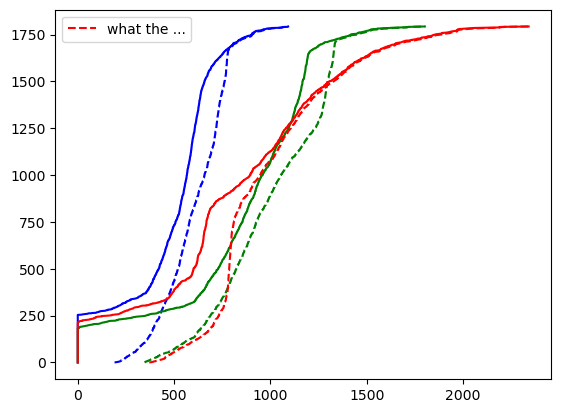

In [16]:
import numpy as np
import matplotlib.pyplot as plt

y = np.random.rand(np.size(ds.msi02_agm))  #creates a random field with the right number of values..
target_n = 10000
if np.size(y) > target_n: 
    rand_cut = target_n/np.size(y)
else: 
    rand_cut = 1
effective_n = np.size(y[np.argwhere(y<rand_cut)])

if True:
    x = np.arange(0,effective_n)
    plt.plot(np.sort(ds['msi02_agmr'].values.reshape(np.size(ds['msi02_agmr'])))[np.argwhere(y<rand_cut)],x,"b-")
    plt.plot(np.sort(ds['msi02_agm' ].values.reshape(np.size(ds['msi02_agm' ])))[np.argwhere(y<rand_cut)],x,"b--" )
    plt.plot(np.sort(ds['msi03_agmr'].values.reshape(np.size(ds['msi02_agm'])))[np.argwhere(y<rand_cut)],x,"g-")
    plt.plot(np.sort(ds['msi03_agm'].values.reshape(np.size(ds['msi02_agm'])))[np.argwhere(y<rand_cut)],x,"g--")
    plt.plot(np.sort(ds['msi04_agmr'].values.reshape(np.size(ds['msi02_agm'])))[np.argwhere(y<rand_cut)],x,"r-")
    plt.plot(np.sort(ds['msi04_agm'].values.reshape(np.size(ds['msi02_agm'])))[np.argwhere(y<rand_cut)],x,"r--",label='what the ...')

plt.legend()
plt.show()

In [17]:
%%memit
ds['hue'] = hue_calculation(ds,instrument='msi_agm')
print(ds)

2025-06-10 23:08:00,255 water_quality.hue [INFO]: Average Hue values pre-adjustment : [60.1 61.1]
2025-06-10 23:08:00,262 water_quality.hue [INFO]: Average Hue values post-ajustment : [53.6 55.4]
<xarray.Dataset> Size: 209kB
Dimensions:              (time: 2, y: 23, x: 39)
Coordinates:
  * time                 (time) datetime64[ns] 16B 2023-07-02T11:59:59.999999...
  * y                    (y) float64 184B -4.072e+06 -4.072e+06 ... -4.072e+06
  * x                    (x) float64 312B 1.881e+06 1.881e+06 ... 1.881e+06
    spatial_ref          int32 4B 6933
Data variables: (12/39)
    oli02_agm            (time, y, x) uint16 4kB 605 618 631 638 ... 491 508 526
    oli03_agm            (time, y, x) uint16 4kB 1076 1095 1114 ... 868 907 945
    oli04_agm            (time, y, x) uint16 4kB 1340 1369 1399 ... 1113 1159
    oli05_agm            (time, y, x) uint16 4kB 3122 3125 3128 ... 2405 2442
    oli06_agm            (time, y, x) uint16 4kB 3126 3173 3220 ... 2657 2715
    oli07_agm      

In [18]:
%%memit
instrument = 'msi_agm'
ds['owt_msi']  = OWT_pixel(ds, instrument)
print(ds)

<xarray.Dataset> Size: 223kB
Dimensions:              (time: 2, y: 23, x: 39)
Coordinates:
  * time                 (time) datetime64[ns] 16B 2023-07-02T11:59:59.999999...
  * y                    (y) float64 184B -4.072e+06 -4.072e+06 ... -4.072e+06
  * x                    (x) float64 312B 1.881e+06 1.881e+06 ... 1.881e+06
    spatial_ref          int32 4B 6933
Data variables: (12/40)
    oli02_agm            (time, y, x) uint16 4kB 605 618 631 638 ... 491 508 526
    oli03_agm            (time, y, x) uint16 4kB 1076 1095 1114 ... 868 907 945
    oli04_agm            (time, y, x) uint16 4kB 1340 1369 1399 ... 1113 1159
    oli05_agm            (time, y, x) uint16 4kB 3122 3125 3128 ... 2405 2442
    oli06_agm            (time, y, x) uint16 4kB 3126 3173 3220 ... 2657 2715
    oli07_agm            (time, y, x) uint16 4kB 2190 2236 2282 ... 1890 1940
    ...                   ...
    msi07_agmr           (time, y, x) float32 7kB 2.911e+03 ... 2.422e+03
    oli04_agmr           (time, y

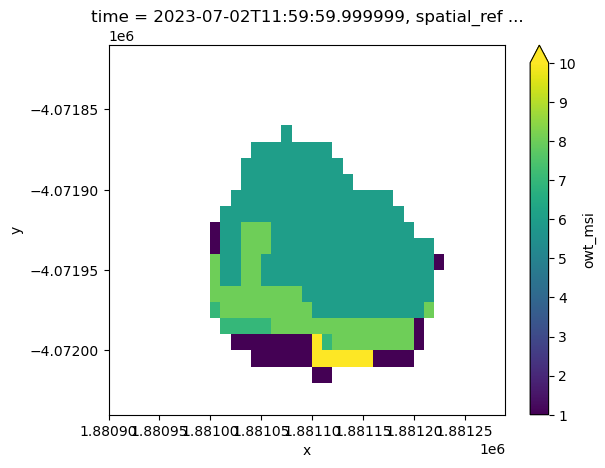

In [19]:
ds['owt_msi'].isel(time=0).plot(vmin=1, vmax=10)

In [20]:
# ---- Apply the WQ algorithms to water areas, adding variables to the dataset and building  a list of water quality variable nanmes
# -- this can be run either keeping the wq variables as separate variables on the dataset, or by moving them into new dimensions, 'tss' and 'chla'
# -- If the arguments 'new_dimension_name' or 'new_varname' are None (or empty), then the outputs will be retained as separate variables in a 3d dataset

if True: #put the data into a new dimension, call the variable 'tss' or 'chla'
    ds,tsm_vlist  = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms= ALGORITHMS_TSM,  
                        instruments_list=instruments_list, 
                        new_dimension_name='tss_measure', 
                        new_varname='tss', 
                        )
    ds,chla_vlist = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms= ALGORITHMS_CHLA,  
                        instruments_list=instruments_list, 
                        new_dimension_name='chla_measure', 
                        new_varname='chla',)
else:  #keep it simple, just add new data as new variables in a 3-D dataset 
    ds,tsm_vlist  = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms= ALGORITHMS_TSM,  
                        instruments_list=instruments_list, 
                        new_dimension_name=None, 
                        new_varname=None, )
    ds,chla_vlist = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms= ALGORITHMS_CHLA,  
                        instruments_list=instruments_list, 
                        new_dimension_name=None, 
                        new_varname=None)
wq_varlist = np.append(tsm_vlist,chla_vlist)

2025-06-10 23:08:00,901 water_quality.wq_algorithms [INFO]: Running  WQ algorithms for: ndssi_rg, ndssi_bnir, ti_yu, tsm_lym, tss_zhang, spm_qiu
2025-06-10 23:08:00,901 water_quality.wq_algorithms [INFO]: Running  WQ algorithm ndssi_rg
2025-06-10 23:08:00,901 water_quality.wq_algorithms [INFO]: Instrument: msi_agm
2025-06-10 23:08:00,902 water_quality.wq_algorithms [INFO]: NDSSI_RG
2025-06-10 23:08:00,905 water_quality.wq_algorithms [INFO]: Instrument: oli_agm
2025-06-10 23:08:00,905 water_quality.wq_algorithms [INFO]: NDSSI_RG
2025-06-10 23:08:00,908 water_quality.wq_algorithms [INFO]: Running  WQ algorithm ndssi_bnir
2025-06-10 23:08:00,909 water_quality.wq_algorithms [INFO]: Instrument: oli_agm
2025-06-10 23:08:00,910 water_quality.wq_algorithms [INFO]: NDSSI_BNIR
2025-06-10 23:08:00,913 water_quality.wq_algorithms [INFO]: Running  WQ algorithm ti_yu
2025-06-10 23:08:00,913 water_quality.wq_algorithms [INFO]: Instrument: oli_agm
2025-06-10 23:08:00,914 water_quality.wq_algorithms [I

In [22]:
ds

<xarray.Dataset> Size: 533kB
Dimensions:              (time: 2, y: 23, x: 39, tss_measure: 10,
                          chla_measure: 6)
Coordinates:
  * time                 (time) datetime64[ns] 16B 2023-07-02T11:59:59.999999...
  * y                    (y) float64 184B -4.072e+06 -4.072e+06 ... -4.072e+06
  * x                    (x) float64 312B 1.881e+06 1.881e+06 ... 1.881e+06
    spatial_ref          int32 4B 6933
  * tss_measure          (tss_measure) <U18 720B 'ndssi_rg_msi_agm' ... 'spm_...
  * chla_measure         (chla_measure) <U20 480B 'ndci_msi54_agm' ... 'chla_...
Data variables: (12/42)
    oli02_agm            (time, y, x) float32 7kB nan nan nan ... nan nan nan
    oli03_agm            (time, y, x) float32 7kB nan nan nan ... nan nan nan
    oli04_agm            (time, y, x) float32 7kB nan nan nan ... nan nan nan
    oli05_agm            (time, y, x) float32 7kB nan nan nan ... nan nan nan
    oli06_agm            (time, y, x) float32 7kB nan nan nan ... nan nan nan
    oli07_agm            (time, y, x) float32 7kB nan nan nan ... nan nan nan
    ...                   ...
    oli03_agmr           (time, y, x) float32 7kB nan nan nan ... nan nan nan
    oli02_agmr           (time, y, x) float32 7kB nan nan nan ... nan nan nan
    hue                  (time, y, x) float64 14kB nan nan nan ... nan nan nan
    owt_msi              (time, y, x) float64 14kB nan nan nan ... nan nan nan
    tss                  (time, y, x, tss_measure) float64 144kB nan nan ... nan
    chla                 (time, y, x, chla_measure) float64 86kB nan nan ... nan
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

In [24]:
# ---- tidy up by dropping excess variables ---
keeplist = ('wofs_ann_clearcount','wofs_ann_wetcount','wofs_ann_freq','wofs_ann_freq_sigma','wofs_pw_threshold','wofs_ann_pwater','watermask','owt_msi','tss','chla')
#the keeplist is not complete; if the wq variables are retained as variables they will appear in a listing of data_vars. 
#therefore, revert to the instruments dictionary to list variables to drop
droplist = []
for instrument in list(instruments_list.keys()):
    for band in list(instruments_list[instrument].keys()):
        variable = instruments_list[instrument][band]['varname']
        if not (variable in keeplist): 
            droplist=np.append(droplist,variable)
            droplist=np.append(droplist,variable+'r')
for varname in droplist:
    if varname in ds.data_vars:
        ds = ds.drop_vars(varname)

In [25]:
ds

<xarray.Dataset> Size: 325kB
Dimensions:              (time: 2, y: 23, x: 39, tss_measure: 10,
                          chla_measure: 6)
Coordinates:
  * time                 (time) datetime64[ns] 16B 2023-07-02T11:59:59.999999...
  * y                    (y) float64 184B -4.072e+06 -4.072e+06 ... -4.072e+06
  * x                    (x) float64 312B 1.881e+06 1.881e+06 ... 1.881e+06
    spatial_ref          int32 4B 6933
  * tss_measure          (tss_measure) <U18 720B 'ndssi_rg_msi_agm' ... 'spm_...
  * chla_measure         (chla_measure) <U20 480B 'ndci_msi54_agm' ... 'chla_...
Data variables: (12/13)
    wofs_ann_freq        (time, y, x) float32 7kB nan nan nan ... nan nan nan
    wofs_ann_clearcount  (time, y, x) float32 7kB nan nan nan ... nan nan nan
    wofs_ann_wetcount    (time, y, x) float32 7kB nan nan nan ... nan nan nan
    wofs_ann_freq_sigma  (time, y, x) float32 7kB nan nan nan ... nan nan nan
    wofs_ann_confidence  (time, y, x) float32 7kB nan nan nan ... nan nan nan
    wofs_pw_threshold    (time, y, x) float32 7kB nan nan nan ... nan nan nan
    ...                   ...
    wofs_ann_water       (time, y, x) float32 7kB nan nan nan ... nan nan nan
    watermask            (time, y, x) float32 7kB nan nan nan ... nan nan nan
    hue                  (time, y, x) float64 14kB nan nan nan ... nan nan nan
    owt_msi              (time, y, x) float64 14kB nan nan nan ... nan nan nan
    tss                  (time, y, x, tss_measure) float64 144kB nan nan ... nan
    chla                 (time, y, x, chla_measure) float64 86kB nan nan ... nan
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

In [26]:
#export the dataset as an input for the next step:
ds.to_netcdf("../WP1.3/wp13_ds.nc")

In [27]:
ds.data_vars

Data variables:
    wofs_ann_freq        (time, y, x) float32 7kB nan nan nan ... nan nan nan
    wofs_ann_clearcount  (time, y, x) float32 7kB nan nan nan ... nan nan nan
    wofs_ann_wetcount    (time, y, x) float32 7kB nan nan nan ... nan nan nan
    wofs_ann_freq_sigma  (time, y, x) float32 7kB nan nan nan ... nan nan nan
    wofs_ann_confidence  (time, y, x) float32 7kB nan nan nan ... nan nan nan
    wofs_pw_threshold    (time, y, x) float32 7kB nan nan nan ... nan nan nan
    wofs_ann_pwater      (time, y, x) float32 7kB nan nan nan ... nan nan nan
    wofs_ann_water       (time, y, x) float32 7kB nan nan nan ... nan nan nan
    watermask            (time, y, x) float32 7kB nan nan nan ... nan nan nan
    hue                  (time, y, x) float64 14kB nan nan nan ... nan nan nan
    owt_msi              (time, y, x) float64 14kB nan nan nan ... nan nan nan
    tss                  (time, y, x, tss_measure) float64 144kB nan nan ... nan
    chla                 (time, y, x, chla_

In [28]:
ds['wofs_ann_confidence'] = ((1.0 - (ds.wofs_ann_freq_sigma/ds.wofs_ann_freq)) * 100).astype('int16')

/opt/conda/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:230: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


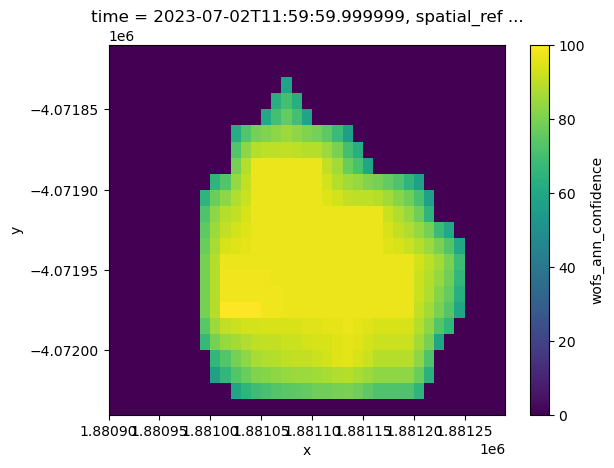

In [29]:
ds.isel(time=0).wofs_ann_confidence.plot()